In [2]:
import nltk
import re
import numpy as np
import pandas as pd
import pprint as pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
import pprint
from pprint import pprint
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

unable to import 'smart_open.gcs', disabling that module


In [3]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.extend(['from','subject','re','edu','use'])

In [4]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [5]:
print(type(df.iloc[[0]].content))

<class 'pandas.core.series.Series'>


In [6]:
data = df.content.values.tolist()

# remove emails
data = [re.sub('\S*@\S*\s?','',sent) for sent in data]

# remove new lines
data = [re.sub('\s+',' ', sent) for sent in data]

# remove single quotes
data = [re.sub("\'","",sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))
        
data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [8]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold = 100)
trigram = gensim.models.Phrases(bigram[data_words],threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [9]:
def remove_stopwords(text):
    return[[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in text]

def make_bigrams(text):
    return [bigram_mod[doc] for doc in text]

def make_trigrams(text):
    return [trigram_mod[bigram_mod[doc]] for doc in text]

def lemmatization(text, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out=[]
    for sent in text:
        doc=nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

        
    return texts_out

In [10]:
data = remove_stopwords(data_words)

data = make_bigrams(data)

nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])

data = lemmatization(data, allowed_postags=['NOUN','ADJ','VERB','ADV'])

print(data[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [11]:
id2word = corpora.Dictionary(data)

corpus = [id2word.doc2bow(text) for text in data]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]]


In [12]:
id2word[0]

'addition'

In [13]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('specs', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [14]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word = id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())

doc_lda=lda_model[corpus]

[(0,
  '0.141*"team" + 0.140*"game" + 0.081*"play" + 0.080*"sale" + 0.033*"nhl" + '
  '0.029*"trade" + 0.029*"cd" + 0.018*"ice" + 0.014*"detroit" + 0.014*"joe"'),
 (1,
  '0.086*"pin" + 0.044*"processor" + 0.044*"character" + 0.040*"font" + '
  '0.034*"mirror" + 0.018*"radius" + 0.018*"quran" + 0.017*"stephen" + '
  '0.014*"ford" + 0.012*"alot"'),
 (2,
  '0.048*"notice" + 0.040*"material" + 0.037*"signal" + 0.037*"external" + '
  '0.030*"circuit" + 0.022*"case_western" + 0.022*"reserve_university" + '
  '0.021*"oil" + 0.018*"charle" + 0.016*"william"'),
 (3,
  '0.054*"not" + 0.034*"do" + 0.028*"would" + 0.026*"be" + 0.021*"say" + '
  '0.020*"think" + 0.019*"know" + 0.017*"go" + 0.016*"people" + 0.015*"get"'),
 (4,
  '0.084*"library" + 0.061*"object" + 0.045*"cub" + 0.011*"static" + '
  '0.008*"compiler" + 0.008*"void" + 0.006*"borland" + 0.006*"bc" + '
  '0.003*"sps" + 0.001*"initialize"'),
 (5,
  '0.112*"israel" + 0.061*"israeli" + 0.045*"jew" + 0.038*"arab" + '
  '0.037*"jewish" + 0.0

In [15]:
print('\n Perplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary = id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


 Perplexity:  -14.150704496578369

Coherence Score: 0.4993186780826996


In [16]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [17]:
# Using Mallet
import os

os.environ['MALLET_HOME'] = 'C:\\Mallet'

mallet_path = 'C:\\Mallet\\bin\\mallet'


ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,corpus=corpus, num_topics=20, id2word=id2word)

In [18]:
pprint(ldamallet.show_topics(formatted=False))

coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = data, dictionary = id2word, coherence='c_v')
coherence_ldamallet=coherence_model_ldamallet.get_coherence()
print('\n Coherence score: ',coherence_ldamallet)

[(13,
  [('armenian', 0.020856049642156184),
   ('book', 0.010903828234967586),
   ('people', 0.010428024821078092),
   ('turkish', 0.009377292282072123),
   ('line', 0.007830931186931267),
   ('turk', 0.007493903768759541),
   ('greek', 0.007077575781606233),
   ('turkey', 0.006760373505679903),
   ('history', 0.006601772367716739),
   ('university', 0.006244919807299618)]),
 (11,
  [('line', 0.031758745296725406),
   ('organization', 0.016782773907536415),
   ('power', 0.010486905338449502),
   ('good', 0.009462429683716425),
   ('sound', 0.008121297917520396),
   ('ground', 0.007748761315799277),
   ('wire', 0.007245836903475767),
   ('current', 0.007208583243303654),
   ('box', 0.00713407592295943),
   ('question', 0.0059792124576239615)]),
 (7,
  [('gun', 0.024298554389802125),
   ('write', 0.020436758825740746),
   ('article', 0.01438775161477735),
   ('line', 0.011346160418304227),
   ('organization', 0.010987321007484365),
   ('people', 0.010628481596664503),
   ('fire', 0.0091

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list=[]
    
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherenceModel = CoherenceModel(model=model,texts = texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherenceModel.get_coherence())
        
    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,texts=data, start=2, limit=40,step=6)

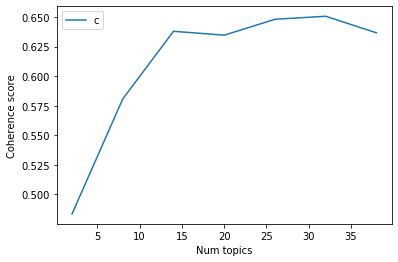

In [21]:
limit=40;start=2;step=6;

x = range(start, limit,step)
plt.plot(x, coherence_values)
plt.xlabel('Num topics')
plt.ylabel('Coherence score')
plt.legend(("coherence_values"),loc='best')
plt.show()

In [22]:
for m, cv in zip(x, coherence_values):
    print("Num topics = ",m," has Coherence Value of: ", round(cv,4))

Num topics =  2  has Coherence Value of:  0.4835
Num topics =  8  has Coherence Value of:  0.5807
Num topics =  14  has Coherence Value of:  0.6379
Num topics =  20  has Coherence Value of:  0.6346
Num topics =  26  has Coherence Value of:  0.648
Num topics =  32  has Coherence Value of:  0.6506
Num topics =  38  has Coherence Value of:  0.6366


In [23]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.016*"people" + 0.015*"time" + 0.011*"start" + 0.011*"day" + '
  '0.011*"happen" + 0.010*"leave" + 0.010*"back" + 0.008*"call" + 0.008*"hear" '
  '+ 0.007*"live"'),
 (1,
  '0.021*"gun" + 0.015*"state" + 0.015*"law" + 0.012*"people" + 0.008*"crime" '
  '+ 0.007*"weapon" + 0.007*"fire" + 0.007*"case" + 0.006*"firearm" + '
  '0.006*"kill"'),
 (2,
  '0.015*"make" + 0.012*"work" + 0.012*"people" + 0.011*"money" + '
  '0.009*"president" + 0.009*"year" + 0.009*"pay" + 0.008*"job" + '
  '0.008*"state" + 0.008*"government"'),
 (3,
  '0.007*"problem" + 0.006*"food" + 0.006*"wire" + 0.006*"ground" + '
  '0.005*"doctor" + 0.005*"disease" + 0.005*"study" + 0.005*"medical" + '
  '0.005*"effect" + 0.005*"patient"'),
 (4,
  '0.033*"file" + 0.021*"line" + 0.014*"read" + 0.014*"program" + 0.014*"set" '
  '+ 0.013*"number" + 0.012*"change" + 0.012*"follow" + 0.011*"problem" + '
  '0.011*"write"'),
 (5,
  '0.015*"question" + 0.011*"point" + 0.011*"exist" + 0.011*"reason" + '
  '0.011*"claim" + 0.

In [24]:
# find dominant topic in each sentence

def format_topic_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_df= pd.DataFrame()
    
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key = lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df =sent_topics_df.append(pd.Series([int(topic_num),round(prop_topic,4),
                                                                topic_keywords]),ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic','Perc_Contribution','Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topic_sentences(ldamodel=optimal_model, corpus = corpus, texts = data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns=['Document_No','Dominant_Topic','Topic_Perc_Contrib','Keywords','Text']

df_dominant_topic.head(10)
                

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.1726,"car, bike, buy, good, organization, line, ride...","[where, s, thing, car, nntp_poste, host, umd, ..."
1,1,12.0,0.2049,"drive, card, problem, system, scsi, work, driv...","[clock, poll, final, call, summary, final, cal..."
2,2,12.0,0.1815,"drive, card, problem, system, scsi, work, driv...","[thomas, willis, question, organization, purdu..."
3,3,12.0,0.1285,"drive, card, problem, system, scsi, work, driv...","[joe, green, weitek, organization, harris, com..."
4,4,4.0,0.1920,"file, line, read, program, set, number, change...","[mcdowell, shuttle_launch, question, organizat..."
5,5,1.0,0.4424,"gun, state, law, people, crime, weapon, fire, ...","[foxvog_douglas, reword, second_amendment, ide..."
6,6,7.0,0.0900,"mail, post, information, send, group, list, ad...","[brian, man, delaney, brain, tumor, treatment,..."
7,7,12.0,0.5742,"drive, card, problem, system, scsi, work, driv...","[grubb, ide_vs, scsi, organization, state, uni..."
8,8,10.0,0.1153,"window, image, version, program, file, display...","[win, icon, help, organization, university, no..."
9,9,12.0,0.1559,"drive, card, problem, system, scsi, work, driv...","[stan_kerr, sigma_designs, double, article, or..."


In [25]:
# most represenatative document for each topic

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'],
                                                                                         ascending=[0]).head(1)],
                                           axis=0)
    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns=['Topic_Num','Topic_Perc_Contrib','Keywords','Text']

sent_topics_sorteddf_mallet
    

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9054,"people, time, start, day, happen, leave, back,...","[david_davidian, account, anti, armenian, huma..."
1,1.0,0.7048,"gun, state, law, people, crime, weapon, fire, ...","[larry_cipriani, gun, talk, state, legislative..."
2,2.0,0.8582,"make, work, people, money, president, year, pa...","[clinton_gore, clinton, background, briefing, ..."
3,3.0,0.7248,"problem, food, wire, ground, doctor, disease, ...","[ground, power, wiring, question, wiring, line..."
4,4.0,0.9746,"file, line, read, program, set, number, change...","[landon_noll, reposte, international_obfuscate..."
5,5.0,0.7041,"question, point, exist, reason, claim, make, a...","[faq, constructing_logical, argument, summary,..."
6,6.0,0.7634,"god, christian, people, bible, religion, man, ...","[robert_weiss, ld, rick, reply, organization, ..."
7,7.0,0.6730,"mail, post, information, send, group, list, ad...","[robert_lipman, call, presentations_navy, sciv..."
8,8.0,0.7582,"year, good, run, game, line, hit, win, organiz...","[time, peak, player, organization, ball, state..."
9,9.0,0.3613,"write, article, line, organization, thing, mak...","[organization, university, illinoi, chicago_ac..."


In [26]:
# topic distribution accross documents
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

topic_contribution = round(topic_counts/topic_counts.sum(),4)

topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic','Topic_Keywords']]

df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis =1)

df_dominant_topics.columns=['Dominant_Topic','Topic_Keywords','Num_Documents','Perc_Documents']

df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,13.0,"car, bike, buy, good, organization, line, ride...",200.0,0.0177
1.0,12.0,"drive, card, problem, system, scsi, work, driv...",615.0,0.0544
2.0,12.0,"drive, card, problem, system, scsi, work, driv...",340.0,0.0301
3.0,12.0,"drive, card, problem, system, scsi, work, driv...",655.0,0.0579
4.0,4.0,"file, line, read, program, set, number, change...",161.0,0.0142
...,...,...,...,...
11309.0,3.0,"problem, food, wire, ground, doctor, disease, ...",NaN,NaN
11310.0,12.0,"drive, card, problem, system, scsi, work, driv...",NaN,NaN
11311.0,12.0,"drive, card, problem, system, scsi, work, driv...",NaN,NaN
11312.0,19.0,"space, system, launch, earth, nasa, center, pr...",NaN,NaN
